# Průvodce implementací bakalářské práce
Tento soubor mapuje workflow následujících činností:
- zpracování dat
- trénování modelu
- evaluace modelu
- optimalizace algoritmických strategií
- obchodování automatizované prahové strategie
- obchodování automatizované prahové strategie s MACD indikátorem

**Tento soubor slouží jako interface**. Funkcionalita je implementována v následujících modulech. 

## Vlastní moduly 
### Dataset Manager
- `dataset_manager.py` - pro správu a manipulaci s daty
- `technical_indicators.py` - technické indikátory
- `datasets` - složka s datasetem ve formátu .csv

### Neural Lab
- `logger.py` - package pro logování informací o natrénovaných modelech
- `ann_clasification.py` - řízení topologie a parametrů modelu
    - `model_builder.py` - sestavení modelu a jeho trénování
    - `model_evaluation.py` - evaluace vytrénovaného modelu
    - `model_strategies.py` - algoritmické strategie a jejich evaluace 

## Importy

In [1]:
# Ignoruje warningy u dependencies
import warnings
warnings.filterwarnings('ignore')

# Python Packages
import os
import sys

# DataScience Packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Add folder into Python Path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Custom Packages
from dataset_manager.dataset_manager import DatasetManager
from neural_network_lab.model_preset.logger import Logger

# Import neural network implementation
from neural_network_lab.ann_classification import ModelNeuralNetwork

Using TensorFlow backend.


## Obchodní data
### Parametry použitých  dat

In [2]:
# Data Parameters
currency_pair = 'USD/JPY'
data_postfix = '12-16'
time_frame = '1H'

### Zpracování dat
1. Importuje data 
2. Vyčistí data od prázdných hodnot
3. Agreguje data na požadovanou hodnotu periody (default = 1H) 
4. Resetuje index
5. Uloží kopii do mezipaměti (slouží primárně k iterování)

In [3]:
# INITIALIZE DATASET
# ------------------------------------------------------------------------------
dm = DatasetManager(currency_pair, data_postfix).resample(time_frame)
dm.df.reset_index(drop=True, inplace=True)
dm.save_df_copy_into_memory()

# First 5 rows
dm.df.head()

Import dataset: usdjpy_12-16.csv
Clean data
Aggregate data on 1H candles


,open,high,low,close
0,76.948,76.991,76.923,76.984
1,76.985,77.002,76.926,76.948
2,76.947,76.947,76.894,76.921
3,76.920,76.924,76.896,76.906
4,76.903,76.914,76.898,76.907


## Neuronová síť
### Inicializace modelu neuronové sítě
Vytvoří instanci modelu, která implementuje celkovou funkcionalitu a pomocné metody pro evaluaci a obchodování

In [4]:
# IMPORT NEURAL NETWORK
# ------------------------------------------------------------------------------
model = ModelNeuralNetwork(data_manager=dm)

Initialize Model Builder
Initialize Model Evaluation
Initialize Model Strategies
Initialize Neural Network Setup


### Důlěžité parametry
**`model.predict_ma`** - Model bude klasifikovat klouzavý průměr o délce `predict_ma`
- parametr délky klasifikovaného klouzavého průměru

**`model.n_past`** - Model uvidí `n_past` period do minulosti.
- parametr délky klouzavého okna

**`model.n_future`** - Model bude predikovat `n_future` period do budoucnosti.
- parametr výpočtu lineární regrese

#### Parametry názvů modelu
- `model.model_task` - prefix názvu modelu
- `model.model_postfix` - postfix názvu modelu

### Import modelu s nejlepší prahovou strategií s MACD indikátorem
Lze přepsat výchozí parametry modelu. Pokud takový model ve složce (`'trained_models'`) existuje a je natrénován, je možné importovat existující váhy.

In [5]:
# Default = model with the best threshold strategy with MACD
model.predict_ma: int = 40
model.n_past: int = 15
model.n_future: int = 5
model.model_task: str = 'classification'
model.model_postfix: str = ''

print(f'Model called {model.model_name} was initiated')

Model called classification_usdjpy_12-16_MA40_past15_fut5_ was initiated


## Tvorba vstupů
### Výpočet indikátorů
- Sada klouzavých průměrů
- RSI indikátor
- Stochastic oscilátor
- uložení indikátorů pro další operace

In [6]:
# Restore dataset to default - for iteration
dm.restore_df()

# INDICATORS
# ------------------------------------------------------------------------------
dm.ewma(model.predict_ma)
if model.predict_ma != 15:
    dm.ewma(15)
if model.predict_ma != 20:
    dm.ewma(20)
if model.predict_ma != 30:
    dm.ewma(30)
if model.predict_ma != 40:
    dm.ewma(40)
if model.predict_ma != 60:
    dm.ewma(60)
dm.rsi_indicator(25)
dm.stochastic_oscilator(25, 3, 3)
# Save indicators
dm.set_indicators(target=model.model_task)

# First 5 rows
dm.df.head()

,open,high,low,close,EWMA40,EWMA15,EWMA20,EWMA30,EWMA60,rsi25,%k,%d
0,76.948,76.991,76.923,76.984,76.984000,76.984000,76.984000,76.984000,76.984000,0.0,NaN,NaN
1,76.985,77.002,76.926,76.948,76.965550,76.964800,76.965100,76.965400,76.965700,0.0,NaN,NaN
2,76.947,76.947,76.894,76.921,76.949951,76.948213,76.948907,76.949603,76.950301,0.0,NaN,NaN
3,76.920,76.924,76.896,76.906,76.938126,76.935462,76.936520,76.937589,76.938666,0.0,NaN,NaN
4,76.903,76.914,76.898,76.907,76.931263,76.928158,76.929380,76.930629,76.931903,0.0,NaN,NaN


### Odvozené vstupy z EMA
- zlogaritmovaná lineární regrese (výnos) za minulé období o délce n_future
- sada rozdílů EMA za 1 období
- sada zlogaritmovaných regresí (výnosů) za 1 období

In [7]:
# Derived Quantities
dm.df['past_price_regression'] = dm.df[dm.mean_indicators[0]] / dm.df[dm.mean_indicators[0]].shift(
    model.n_future)
dm.df['past_log_regression'] = np.log(dm.df['past_price_regression'])
for mean_average in dm.mean_indicators:
    dm.df['mean_diff_{}'.format(mean_average[-2:])] = dm.df[mean_average] - dm.df[
        mean_average].shift(1)
    dm.df['mean_ret_{}'.format(mean_average[-2:])] = np.log(
        dm.df[mean_average] / dm.df[mean_average].shift(1))

### Výpočet klasifikačních tříd
- třída 1: klouzavý průměr za budoucích n_future period rostl
- třída 0: klouzavý průměr za budoucích n_future period klesal

In [8]:
# CLASSIFICATION VALUES
dm.df['future_price_regression'] = dm.df[dm.mean_indicators[0]].shift(-model.n_future) / dm.df[
    dm.mean_indicators[0]]
dm.df[model.model_task] = np.where(dm.df['future_price_regression'] > 1, 1, 0)

### Odstranění nepotřebných dat
- odstraní se nepotřebné sloupce
- odstraní se těsné okraje datasetu, na kterých se nachází prázdné hodnoty ve sloupcích indikátorů (indikátor neměl dostatek dat, proto nemohl spočítat hodnotu)
- resetování indexu a uložení zbývajících idikátorů


In [9]:
# Drop unnecessary values
dm.df.drop(['low', 'high', 'open'], axis=1, inplace=True)
dm.df.drop(['%d', 'past_price_regression', 'future_price_regression'], axis=1, inplace=True)
# for training without mean averages
# dm.df.drop(model.mean_indicators, axis=1, inplace=True)
dm.df = dm.df.iloc[30:-5]
dm.df.reset_index(drop=True, inplace=True)
dm.set_indicators(target=model.model_task)
df = dm.df

## Rozdělení datasetu na Test / Train
- rozdělí dle parametru v třídě modelu, defaultně je velikost **test datasetu 20 %** z celkových dat - 
    - Default - `model.test_size = 0.2`
- validační dataset se vytvoří automaticky při začátku trénování, defaultně je **velikost 15 % z trénovacího setu**
    - Default - `model.val_size = 0.15`

In [10]:
# Test/Train split
df_train, df_test, df_test_close = dm.test_train_split(model)

# First 5 rows
df_train.head()

,EWMA40,EWMA15,EWMA20,EWMA30,EWMA60,rsi25,%k,past_log_regression,mean_diff_40,mean_ret_40,mean_diff_15,mean_ret_15,mean_diff_20,mean_ret_20,mean_diff_30,mean_ret_30,mean_diff_60,mean_ret_60,classification
0,76.826504,76.782537,76.797978,76.816390,76.836995,33.560477,21.125265,-0.000509,-0.006172,-0.000080,-0.007208,-0.000094,-0.007197,-0.000094,-0.006650,-0.000087,-0.005577,-0.000073,0
1,76.819322,76.773215,76.789145,76.808531,76.830597,32.242226,24.628450,-0.000551,-0.007181,-0.000093,-0.009322,-0.000121,-0.008833,-0.000115,-0.007858,-0.000102,-0.006398,-0.000083,0
2,76.814111,76.768126,76.783594,76.803052,76.825801,35.760518,27.070064,-0.000495,-0.005211,-0.000068,-0.005089,-0.000066,-0.005551,-0.000072,-0.005480,-0.000071,-0.004796,-0.000062,0
3,76.805093,76.754843,76.771713,76.792972,76.817929,31.625183,21.661738,-0.000466,-0.009018,-0.000117,-0.013282,-0.000173,-0.011880,-0.000155,-0.010080,-0.000131,-0.007872,-0.000102,0
4,76.797590,76.745147,76.762511,76.784759,76.811266,33.771930,20.289278,-0.000457,-0.007503,-0.000098,-0.009696,-0.000126,-0.009202,-0.000120,-0.008213,-0.000107,-0.006662,-0.000087,0


## Normalizace dat
Vstupy se normalizují pomocí **Z-Score** metody.

In [11]:
# NORMALIZATION
# ------------------------------------------------------------------------------
scaler = StandardScaler()
scaled_df_train = scaler.fit_transform(df_train[dm.mean_indicators + dm.indicators])
scaled_df_test = scaler.transform(df_test[dm.mean_indicators + dm.indicators])

## Vytvoření vstupních vektorů - plovoucí okna
Pomocí implementované metody klouzavých oken se proiterují datasety a vytvoří se vstupní trénovací a testovací vektory.

In [12]:
# CREATE INPUT VECTORS
# ------------------------------------------------------------------------------
x_train, y_train = model.create_train_vectors(df_train, scaled_df_train)
x_test, y_test, y_test_price = model.create_test_vectors(df_test, scaled_df_test, df_test_close)

## Trénování neuronové sítě
1. Model **dosadí hyperparametry **
2. Model se **sestaví**
3. Model definuje chování během trénování = **Callbacks**
    - dynamické trénování
    - dynamický learning rate
    - model checkpoint
    

4. Model **spustí proces učení**
5. **Váhy se ukládají** během učení, pokud model dosáhne nového lepšího výsledku
6. Model **ukončí své trénování**, pokud se nadále nezlepšuje
7. Model uloží své **trénovací, validační skóre**

#### Poznámka:
parametr `verbose=1` - zobrazí proces trénování

### ! Warning !
Přeučení modelu přepíše uložené váhy modelu. 

In [13]:
# TRAIN NETWORK
# ------------------------------------------------------------------------------

# WARNING - This will overwrite saved weights !!!
# trained_model, training_history = model.train_network(x_train, y_train, verbose=0)

# Plot Training Progress of Accuracy
# model.plot_training_metric()

# Plot Training Progress of Error
# model.plot_training_loss()

## Klasifikace hodnot
- **načte váhy** modelu uložené během trénování
- **klasifikuje třídy** na testovacím / trénovacím / validačním set

In [14]:
# MAKE PREDICTION
# ------------------------------------------------------------------------------
# Load Model Weights
classifier = model.load_network()
# Make Predictions
predictions_train = classifier.predict(x_train)
predictions_test = classifier.predict(x_test)
# Set real values for evaluation
actual_train = y_train
actual_test = y_test

Neural Network successfully compiled
Weights successfully imported
Model is ready to predict.


## Evaluace modelů
### Vytvoření setů pro evaluaci
- **Sloupce**: Aktuální hodnoty + Predikované hodnoty + Uzavírací cena

In [15]:
# CREATE SETS FOR EVALUATION
# Columns: Actual, Prediction, Close Price
# ------------------------------------------------------------------------------
# TRAIN Evaluation Set
df_train_eval = model.create_train_eval_set(actual_train, predictions_train)
# VALIDATION Evaluation Set
df_val_eval = model.create_val_eval_set(actual_train, predictions_train)
# TEST Evaluation Set
df_test_eval = model.create_test_eval_set(actual_test, predictions_test, y_test_price)

### Přesnost na testovacím setu

In [16]:
# ACCURACY EVALUATION
# ------------------------------------------------------------------------------
model.test_score = model.calc_acc(df_train_eval.copy(), origin=0.5, actual_col='actual', prediction_col='prediction')

Models Accuracy on the Test set is: 83.62 %


### Matice záměn - na testovacích datech

In [17]:
# CONFUSION MATRIX - Test set
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_test,predictions_test.round())

array([[2553,  488],
       [ 547, 2610]], dtype=int64)

### Report evaluace klasifikace
Predikce je třeba zaokrouhlit na čistě binární hodnoty pro použití sklearn funkce
- `0` - třída klasifikace poklesu kurzu
- `1` - třída klasifikace růstu kurzu

In [18]:
# EVALUATION REPORT - Test set
from sklearn.metrics import classification_report
print(classification_report(actual_test, predictions_test.round()))

             precision    recall  f1-score   support

          0       0.82      0.84      0.83      3041
          1       0.84      0.83      0.83      3157

avg / total       0.83      0.83      0.83      6198



## Prahová obchodní strategie

In [19]:
best_strategies_evaluations = []

### Optimalizace prahu (threshold)
Optimalizace probíhá mezi hodnotami 0 - 0.45. 

In [20]:
strategies = []
for threshold in np.linspace(0, 0.45, 61):
    df_eval = df_train_eval.copy()
    # Calc without drawdown, it is very time consuming
    strategy = model.prediction_strategy(df_eval, origin=0.5, threshold=threshold,
                                         calc_drawdown=False)
    strategies.append(strategy)
df_strategies = pd.DataFrame(data=strategies,
                             columns=['threshold', 'pip_profit', 'sharpe', 'winrate',
                                      'drawdown', 'fees', 'trades_n', ])

#### Uložení výsledků optimalizace do .csv

In [21]:
df_strategies.to_csv(f'{model.models_folder}/{model.model_name}/pred_strategy_optimization.csv',
                     encoding='utf-8',
                     index=False)

#### Uložení optimalizovaného prahu do atributu
- slouží k evaluaci na dalších částech dat

In [22]:
model.set_pred_best_threshold(df_strategies)

#### Vizualizace optimalizace prahové strategie

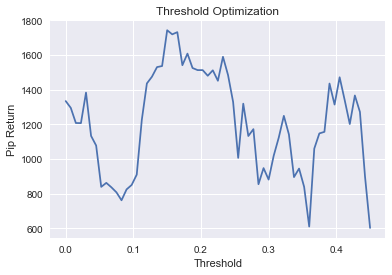

In [23]:
model.plot_threshold_optimization(df_strategies, plot_name='threshold_nn_pred_optimization')

### Obchodování na trénovacích datech

In [24]:
df_eval = df_train_eval.copy()
strategy = model.prediction_strategy(df_eval, origin=0.5,
                                     threshold=model.nn_pred_strategy_best_threshold)
strategy.insert(0, 'train_nn_pred')
# SAVE to list of strategies
best_strategies_evaluations.append(strategy)
# Save profit for logger
model.nn_pred_train_pip_return = model.get_cumulative_pip_return(df_eval)

# Get strategy as dictionary
strategy_dict = model.prediction_strategy(df=df_train_eval.copy(), origin=0.5,
                                          threshold=model.nn_pred_strategy_best_threshold,
                                          form='dict')
# Print Results
model.print_strategy_results(strategy_dict)

Strategy Results:
threshold: 0.15
pip_profit: 1743.3
sharpe: 0.00767
winrate: 30.25
max_drawdown: 1359.2
pip_fees: 1774.5
n_trades: 1183


#### Vizualizace obchodování na trénovacích datech

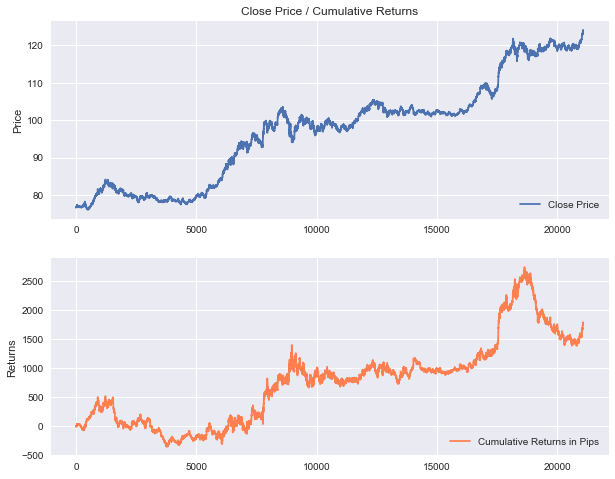

In [25]:
model.plot_cumulative_returns(df_eval, 'nn_pred_train_returns')

### Obchodování na validačních datech

In [26]:
df_eval = df_val_eval.copy()
strategy = model.prediction_strategy(df_eval, origin=0.5,
                                     threshold=model.nn_pred_strategy_best_threshold)
strategy.insert(0, 'val_nn_pred')
# SAVE to list of strategies
best_strategies_evaluations.append(strategy)
# SAVE to parameters for Logger
model.nn_pred_val_pip_return = model.get_cumulative_pip_return(df_eval)

# Get strategy as dictionary
strategy_dict = model.prediction_strategy(df=df_val_eval.copy(), origin=0.5,
                                          threshold=model.nn_pred_strategy_best_threshold,
                                          form='dict')
# Print Results
model.print_strategy_results(strategy_dict)

Strategy Results:
threshold: 0.15
pip_profit: 91.5
sharpe: 0.00202
winrate: 25.13
max_drawdown: 626.6
pip_fees: 298.5
n_trades: 199


#### Vizualizace obchodování na validačních datech

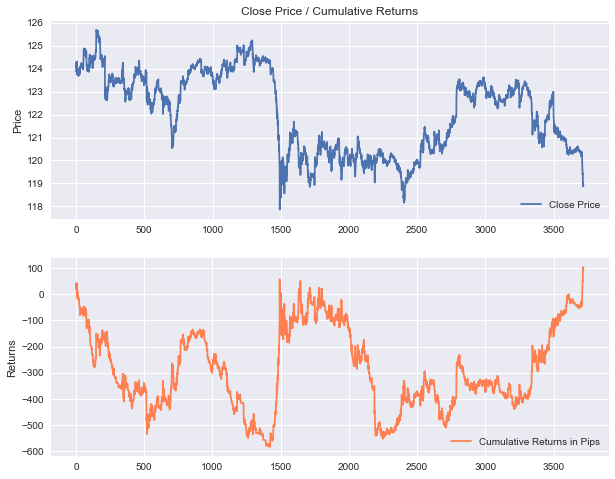

In [27]:
model.plot_cumulative_returns(df_eval, 'nn_pred_test_returns')

### Obchodování na testovacích datech

In [28]:
df_eval = df_test_eval.copy()
strategy = model.prediction_strategy(df_eval, origin=0.5,
                                     threshold=model.nn_pred_strategy_best_threshold)
strategy.insert(0, 'test_nn_pred')
# SAVE to list of strategies
best_strategies_evaluations.append(strategy)

# Get strategy as dictionary
strategy_dict = model.prediction_strategy(df=df_test_eval.copy(), origin=0.5,
                                          threshold=model.nn_pred_strategy_best_threshold,
                                          form='dict')
# Print Results
model.print_strategy_results(strategy_dict)

# Save for logger
model.set_nn_pred_strategy_parameters(strategy_dict)

Strategy Results:
threshold: 0.15
pip_profit: 1335.2
sharpe: 0.01321
winrate: 31.65
max_drawdown: 695.1
pip_fees: 568.5
n_trades: 379


#### Vizualizace obchodování na testovacích datech

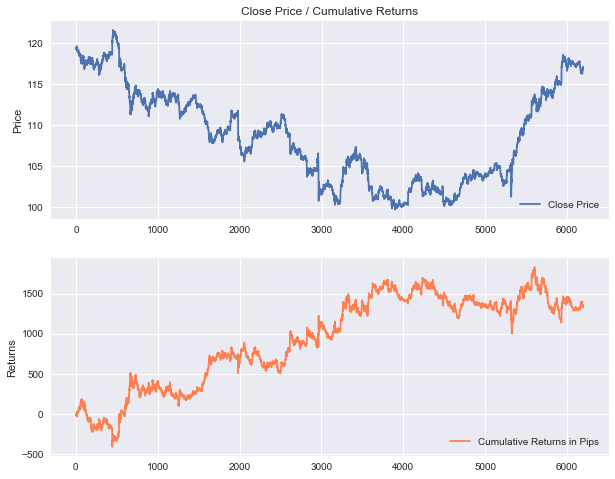

In [29]:
model.plot_cumulative_returns(df_eval, 'nn_pred_test_returns')

## Prahová obchodní strategie s indikátorem MACD

### Optimalizace prahu (threshold)

In [30]:
# MACD Strategy optimization
strategies = []
for threshold in np.linspace(0, 0.45, 61):
    df_eval = df_train_eval.copy()
    # Calc without drawdown, it is very time consuming
    strategy = model.macd_strategy(df_eval, origin=0.5, threshold=threshold, calc_drawdown=False)
    strategies.append(strategy)
df_strategies = pd.DataFrame(data=strategies,
                             columns=['threshold', 'pip_profit', 'sharpe', 'winrate', 'drawdown',
                                      'fees', 'trades_n'])

#### Uložení výsledků optimalizace do .csv

In [31]:
# SAVE Strategies into CSV
df_strategies.to_csv('trained_models/{}/macd_strategy_optimization.csv'.format(model.model_name),
                     encoding='utf-8',
                     index=False)

#### Uložení prahu do atributu

In [32]:
model.set_macd_best_threshold(df_strategies)

#### Vizualizace prahove optimalizace prahové strategie s MACD indikátorem

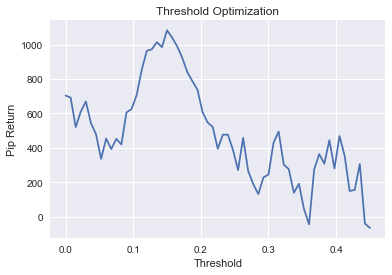

In [33]:
model.plot_threshold_optimization(df_strategies, 'threshold_macd_optimization')

### Obchodování na trénovacích datech

In [34]:
# MACD STRATEGY
df_eval = df_train_eval.copy()
strategy = model.macd_strategy(df_eval, origin=0.5, threshold=model.macd_strategy_best_threshold)
strategy.insert(0, 'train_macd')
# SAVE to list of strategies
best_strategies_evaluations.append(strategy)
# SAVE to parameters for Logger
model.macd_strategy_train_pip_return = model.get_cumulative_pip_return(df_eval)

# Get strategy as dictionary
strategy_dict = model.macd_strategy(df=df_train_eval.copy(), origin=0.5,
                                    threshold=model.macd_strategy_best_threshold, form='dict')
# Print Results
model.print_strategy_results(strategy_dict)

Strategy Results:
threshold: 0.15
pip_profit: 1083.1
sharpe: 0.00579
winrate: 29.47
max_drawdown: 827.9
pip_fees: 1957.5
n_trades: 1305.0


#### Vizualizace obchodování na trénovacích datech

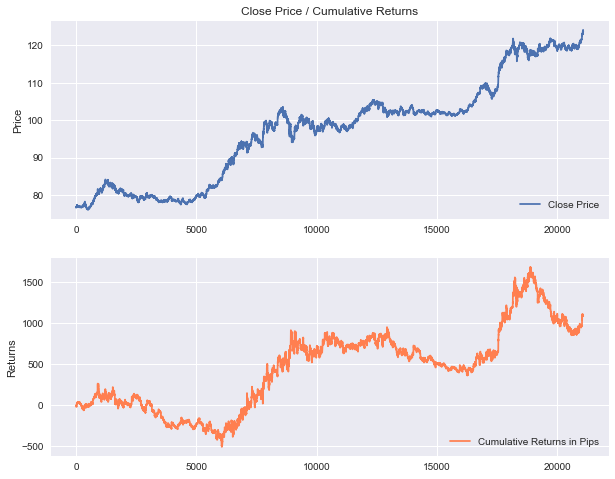

In [35]:
model.plot_cumulative_returns(df_eval, 'macd_train_returns')

### Obchodování na validačních datech

In [36]:
# MACD STRATEGY
df_eval = df_val_eval.copy()
strategy = model.macd_strategy(df_eval, origin=0.5, threshold=model.macd_strategy_best_threshold)
strategy.insert(0, 'val_macd')
# SAVE to list of strategies
best_strategies_evaluations.append(strategy)
# SAVE to parameters for Logger
model.macd_strategy_val_pip_return = model.get_cumulative_pip_return(df_eval)

# Get strategy as dictionary
strategy_dict = model.macd_strategy(df=df_val_eval.copy(), origin=0.5,
                                    threshold=model.macd_strategy_best_threshold, form='dict')
# Print Results
model.print_strategy_results(strategy_dict)

Strategy Results:
threshold: 0.15
pip_profit: 341.8
sharpe: 0.00896
winrate: 21.7
max_drawdown: 396.5
pip_fees: 324.0
n_trades: 216.0


#### Vizualizace obchodování na validačních datech

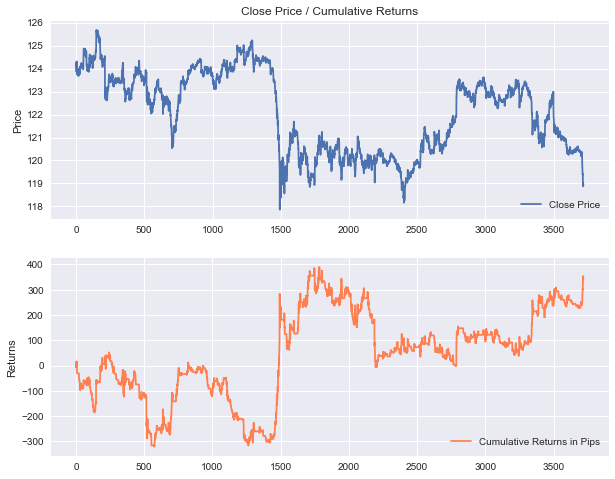

In [37]:
model.plot_cumulative_returns(df_eval, 'macd_val_returns')

### Obchodování na testovacích datech

In [38]:
# MACD STRATEGY
df_eval = df_test_eval.copy()
strategy = model.macd_strategy(df_eval, origin=0.5, threshold=model.macd_strategy_best_threshold)
strategy.insert(0, 'test_macd')
# SAVE to list of strategies
best_strategies_evaluations.append(strategy)

# Get strategy as dictionary
strategy_dict = model.macd_strategy(df=df_test_eval.copy(), origin=0.5,
                                    threshold=model.macd_strategy_best_threshold, form='dict')

# Print Results
model.print_strategy_results(strategy_dict)

# Save results for logger
model.set_macd_strategy_parameters(strategy_dict)

Strategy Results:
threshold: 0.15
pip_profit: 1347.3
sharpe: 0.01591
winrate: 28.97
max_drawdown: 465.2
pip_fees: 600.0
n_trades: 400.0


#### Vizualizace obchodování na testovacích datech

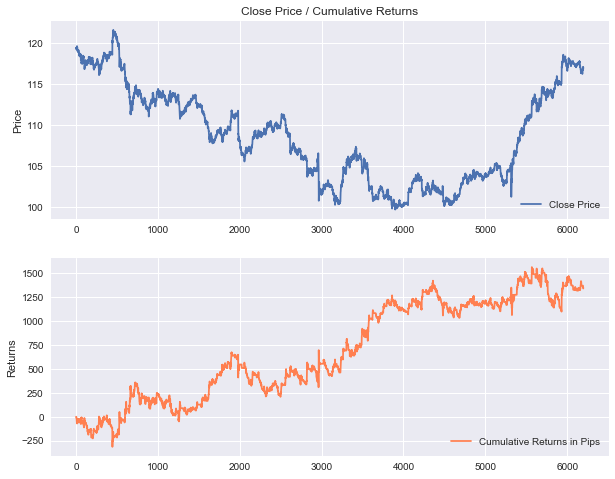

In [39]:
model.plot_cumulative_returns(df_eval, 'nn_pred_test_returns')

## Celkové výsledky obchodování

In [40]:
df_strategies_eval = pd.DataFrame(data=best_strategies_evaluations,
                                  columns=['type', 'threshold', 'pip_profit', 'sharpe', 'winrate',
                                           'drawdown', 'fees', 'trades_n'])
df_strategies_eval.head(6)

,type,threshold,pip_profit,sharpe,winrate,drawdown,fees,trades_n
0,train_nn_pred,0.15,1743.3,0.00767,30.25,1359.2,1774.5,1183.0
1,val_nn_pred,0.15,91.5,0.00202,25.13,626.6,298.5,199.0
2,test_nn_pred,0.15,1335.2,0.01321,31.65,695.1,568.5,379.0
3,train_macd,0.15,1083.1,0.00579,29.47,827.9,1957.5,1305.0
4,val_macd,0.15,341.8,0.00896,21.70,396.5,324.0,216.0
5,test_macd,0.15,1347.3,0.01591,28.97,465.2,600.0,400.0


### Uložení výsledků do .csv

In [41]:
df_strategies_eval.to_csv(
    f'{model.models_folder}/{model.model_name}/best_strategies_evaluation.csv',
    encoding='utf-8', index=False)

## Logger
Uchovává základní informace o parametrech modelu a výsledky jeho evaluace. Soubor je vytvořen ve složce modelu.

In [43]:
# LOGGER
# ------------------------------------------------------------------------------
# Init logger
logger = Logger()
logger.set_model(model)
logger.set_data_manager(dm)
# Log model parameters
logger.log_model_info()

Model was synchronized with Logger
Data Manager was synchronized with Logger
Model Parameters and Results were saved into log file
